### Важно:
Пожалуйста, поддерживайте ваш код в хорошем состоянии, пишите комментарии, убирайте бесполезные ячейки, пишите модели в специально отведенных модулях. Проверяющие могут **НА СВОЕ УСМОТРЕНИЕ** снижать баллы за:

1. Говнокод
2. Неэффективные решения
3. Вермишель из ячеек в тетрадке
4. Все остальное что им не понравилось

#### (0 - 0.05 балла):

За использование логгеров типа wandb/comet/neptune и красивую сборку этой домашки в виде графиков/картинок в этих логгерах мы будем выдавать бонусные баллы.

Решением домашки является архив с использованными тетрадками/модулями, а так же **.pdf** файл с отчетом по проделанной работе по каждому пункту задачи. В нем необходимо описать какие эксперименты вы производили чтобы получить результат который вы получили, а так же обосновать почему вы решили использовать штуки которые вы использовали (например, дополнительные лоссы для стабилизации, разные виды потоков, разные хаки для вае)


In [1]:
import os

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

from tqdm.notebook import tqdm

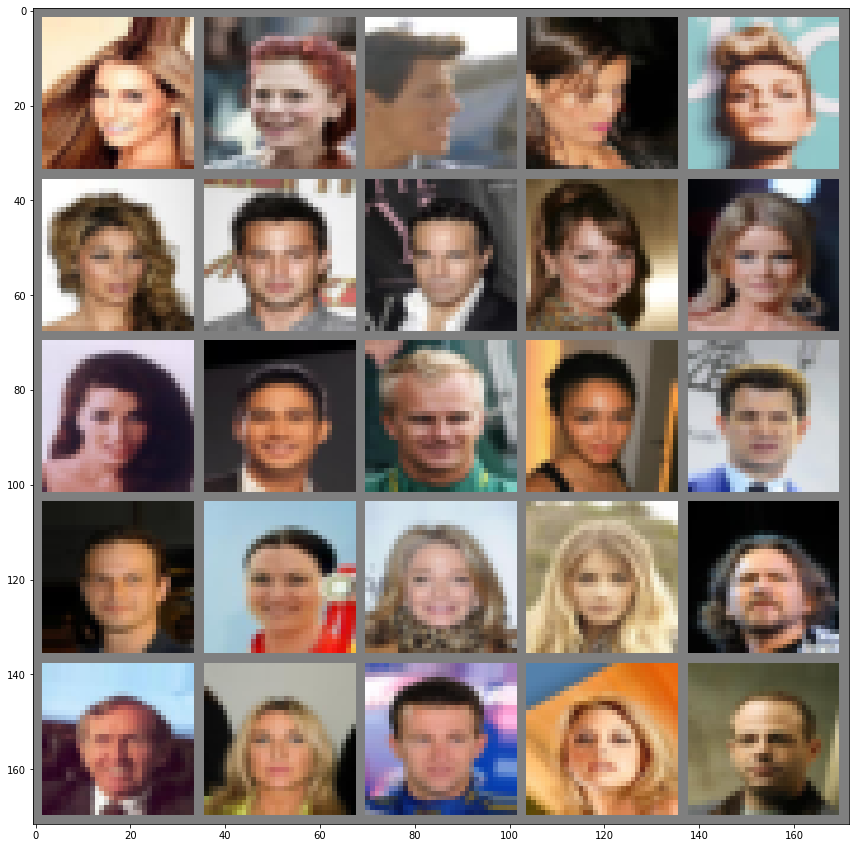

In [2]:
batch_size = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_size = 32

celeba_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
    


full_dataset = torchvision.datasets.CelebA('./celeba/',
                                           transform=celeba_transforms,
                                           download=False)

dataloader = torch.utils.data.DataLoader(dataset=full_dataset,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         drop_last=True)

train_size = int(len(full_dataset))
val_size = 5000
# val_size = int(train_size * 0.1) 
train_size = int(train_size - val_size) 
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=15, drop_last=True)
dataloader_val = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=True, num_workers=15, drop_last=True)

plt.figure(figsize=(15,15))
plt.imshow(make_grid([full_dataset[i][0] for i in range(25)], nrow=5).permute(1,2,0) * 0.5 + 0.5)
plt.show()

В этой домашней работе вам предлагается повторить результаты статьи VAE+NF (https://arxiv.org/pdf/1611.05209.pdf).

Основная часть домашнего задания - чтение статьи и повторение результатов, поэтому обязательно прочитайте не только ее, но и другие основные статьи про потоки того времени:

1. https://arxiv.org/abs/1505.05770
2. https://arxiv.org/abs/1605.08803
3. https://arxiv.org/abs/1705.07057
4. http://arxiv.org/abs/1807.03039




### Задача 1 (0.1 балла, но если не сделаете, за всю домашку ноль):

Для начала предлагаю попробовать обучить обычный VAE на Celeba до нормального качества, померить FID и запомнить для будущего сравнения


In [3]:
import wandb
wandb.init(project='VAE vs NF', reinit=True), #resume='17jrk0bz')

wandb: Currently logged in as: psfed0r0v (use `wandb login --relogin` to force relogin)


(<wandb.sdk.wandb_run.Run at 0x7faf0f3066d8>,)

In [3]:
# The code is taken from https://github.com/ku2482/vae.pytorch

class Encoder(nn.Module):
    def __init__(self, nc, nef, nz, isize, device):
        super(Encoder, self).__init__()

        # Device
        self.device = device

        # Encoder: (nc, isize, isize) -> (nef*8, isize//16, isize//16)
        self.encoder = nn.Sequential(
            nn.Conv2d(nc, nef, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef),

            nn.Conv2d(nef, nef*2, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*2),

            nn.Conv2d(nef*2, nef*4, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*4),

            nn.Conv2d(nef*4, nef*8, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*8)
        )

        # Map the encoded feature map to the latent vector of mean, (log)variance
        out_size = isize // 16
        self.mean = nn.Linear(nef*8*out_size*out_size, nz)
        self.logvar = nn.Linear(nef*8*out_size*out_size, nz)

    @staticmethod
    def reparametrize(mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, inputs):
        # Batch size
        batch_size = inputs.size(0)
        # Encoded feature map
        hidden = self.encoder(inputs)
        # Reshape
        hidden = hidden.view(batch_size, -1)
        # Calculate mean and (log)variance
        mean, logvar = self.mean(hidden), self.logvar(hidden)
        # Sample
        latent_z = self.reparametrize(mean, logvar)

        return latent_z, mean, logvar

class Decoder(nn.Module):
    def __init__(self, nc, ndf, nz, isize):
        super(Decoder, self).__init__()

        # Map the latent vector to the feature map space
        self.ndf = ndf
        self.out_size = isize // 16
        self.decoder_dense = nn.Sequential(
            nn.Linear(nz, ndf*8*self.out_size*self.out_size),
            nn.ReLU(True)
        )
        # Decoder: (ndf*8, isize//16, isize//16) -> (nc, isize, isize)
        self.decoder_conv = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*8, ndf*4, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf*4, 1.e-3),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*4, ndf*2, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf*2, 1.e-3),
        
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*2, ndf, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf, 1.e-3),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf, nc, 3, padding=1)
        )

    def forward(self, input):
        batch_size = input.size(0)
        hidden = self.decoder_dense(input).view(
            batch_size, self.ndf*8, self.out_size, self.out_size)
        output = self.decoder_conv(hidden)
        return output

class VAE(nn.Module):
    def __init__(self, nc=3, ndf=32, nef=32, nz=100, isize=64, device=torch.device("cuda:0"), is_train=True):
        super(VAE, self).__init__()

        self.nz = nz
        self.isize=isize
        # Encoder
        self.encoder = Encoder(nc=nc, nef=nef, nz=nz, isize=isize, device=device)
        # Decoder
        self.decoder = Decoder(nc=nc, ndf=ndf, nz=nz, isize=isize)

        if is_train == False:
            for param in self.encoder.parameters():
                param.requires_grad = False
            for param in self.decoder.parameters():
                param.requires_grad = False

    def forward(self, x):
        latent_z, mean, logvar = self.encoder(x)
        rec_x = self.decoder(latent_z)
        return rec_x, mean, logvar
    
    def encode(self, x):
        latent_z, _, _ = self.encoder(x)
        return latent_z

    def decode(self, z):
        return self.decoder(z)

    @staticmethod
    def reparametrize(mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def sample(self, size, img_size=64):
        sample = torch.randn(size, self.nz).to(self.device)
        return model.decode(sample)
    
    @property
    def device(self): return next(self.parameters()).device

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [5]:
import torch.nn.functional as F
from fid import calculate_fid
from pathlib import Path

dir_checkpoint = 'models_checkpoints'
Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)

load_model = True

def loss_function(recon_x, x, mu, logvar):
    batch_size = recon_x.shape[0]
    MSE = F.mse_loss(recon_x.view(batch_size,-1), x.view(batch_size, -1), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE, KLD

log_interval = 100
epochs = 10

def train():
    model.train()
    train_mse, train_kld, train_loss = 0, 0, 0
    for batch_idx, data in tqdm(enumerate(dataloader_train), total=len(dataloader_train)):
        data = data[0].to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        mse_loss, kld_loss = loss_function(recon_batch, data, mu, logvar)
        loss = mse_loss + kld_loss
        loss.backward()
        train_loss += loss.item();
        train_mse += mse_loss.item(); train_kld += kld_loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            wandb.log({
                'VAE loss': loss.item(),
                'KL': kld_loss.item()/len(data),
                'MSE': mse_loss.item()/len(data)
            })
    wandb.log({'FID VAE': calculate_fid(model, dataloader_val)})

if load_model:
    model = VAE()
    model.load_state_dict(torch.load(f'{dir_checkpoint}/VAE.pth'))
    model.to(device)
    model.eval()
else:
    for epoch in tqdm(range(1, epochs + 1), total=epochs):
        train()
        with torch.no_grad():
            sample = model.sample(batch_size).cpu()
            wandb.log({'VAE sampled images': [wandb.Image(make_grid(sample), caption=f'sample {epoch}')]})
        if not os.path.exists(dir_checkpoint):
            os.makedirs(dir_checkpoint)
        torch.save(model.state_dict(), f'{dir_checkpoint}/VAE.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


FID: 71.84291213577183


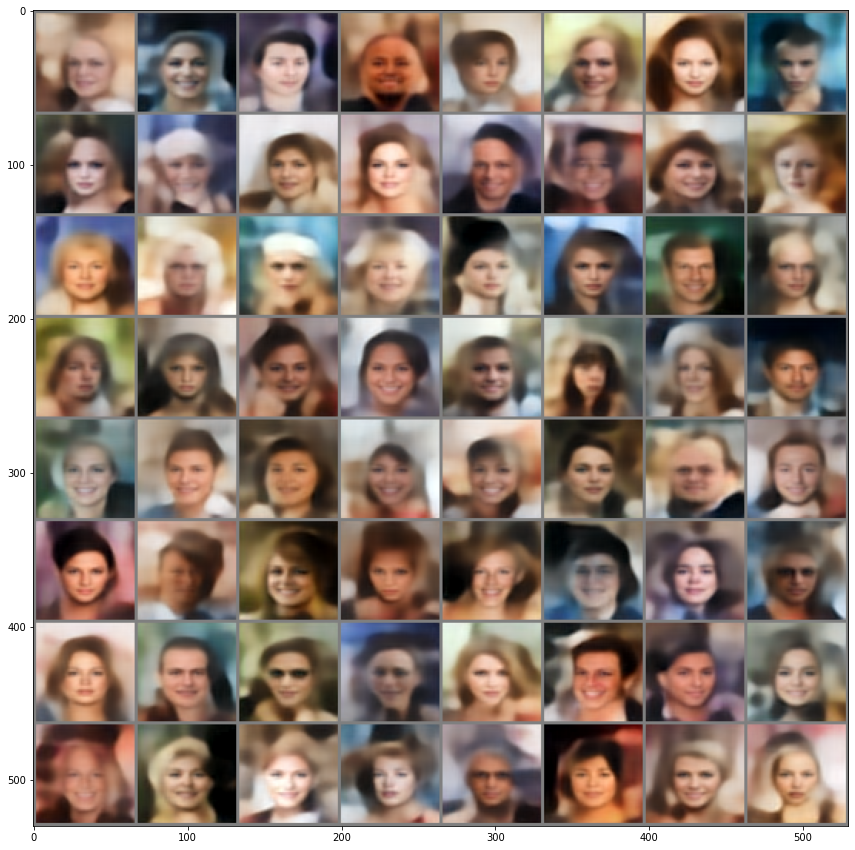

In [6]:
print('FID:', calculate_fid(model, dataloader_val, device))
with torch.no_grad():
    sample = model.sample(64).cpu()
    log_img = make_grid(sample)
plt.figure(figsize=(15,15))
plt.imshow(log_img.permute(1,2,0) * 0.5 + 0.5);

### VAE FID 71,84

### Задача 2 (0.3 балла, но если не сделаете, за всю домашку max 0.1 за прошлый пункт):

После этого попробуем обучить обычный NF на Celeba до нормального качества, померить FID и запомнить для будущего сравнения

В качестве потока можно использовать все что вы хотите, Coupling/Autoregressive/Linear слои, любые трансформации. 

Можно использовать как и сверточные потоки, так и линейные (развернув селебу в один вектор)

In [6]:
batch_size = 32
img_size = 32

celeba_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])
    

full_dataset = torchvision.datasets.CelebA('./celeba/',
                                           transform=celeba_transforms,
                                           download=False)

dataloader = torch.utils.data.DataLoader(dataset=full_dataset,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         drop_last=True)

train_size = int(len(full_dataset))
val_size = 5000
# val_size = int(train_size * 0.1) 
train_size = int(train_size - val_size) 
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=15, drop_last=True)
dataloader_val = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=True, num_workers=15, drop_last=True)

In [7]:
from models import RealNVP, RealNVPLoss
import util

load_model = True

net = RealNVP(num_scales=2, in_channels=3, mid_channels=32, num_blocks=8)
loss_fn = RealNVPLoss()
if load_model:
    net.load_state_dict(torch.load(f'{dir_checkpoint}/Real_NVP_{20}.pth'))
    net.eval()
param_groups = util.get_param_groups(net, 5e-5, norm_suffix='weight_g')
net.to(device)
optimizer = torch.optim.Adam(param_groups, lr=1e-3)

In [ ]:
from fid import calculate_fid

num_epochs = 20

for epoch in range(1, num_epochs + 1):
    net.train()
    for ind, (x, _) in tqdm(enumerate(dataloader_train), total=len(dataloader_train)):
        x = x.to(device)
        optimizer.zero_grad()
        z, sldj = net(x, reverse=False)
        loss = loss_fn(z, sldj)
        loss.backward()
        util.clip_grad_norm(optimizer, 100.0)
        optimizer.step()
        if ind % 100 == 0 and ind != 0:
            wandb.log({'NF loss': loss.item()})
    s = net.sample(64, img_size)
    log_img = make_grid(s)
    fid = calculate_fid(net, dataloader_val, device,
                        img_size=img_size, normalize_input=True)
    sampled_images_to_log = [wandb.Image(log_img.to('cpu'),
                                         caption=f'epoch {epoch}')]
    wandb.log({
        'NF fid': fid,
        'NF sampled images': sampled_images_to_log
    })
    torch.save(net.state_dict(), f'{dir_checkpoint}/Real_NVP_{epoch}.pth')

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



FID: 271.6724735556145


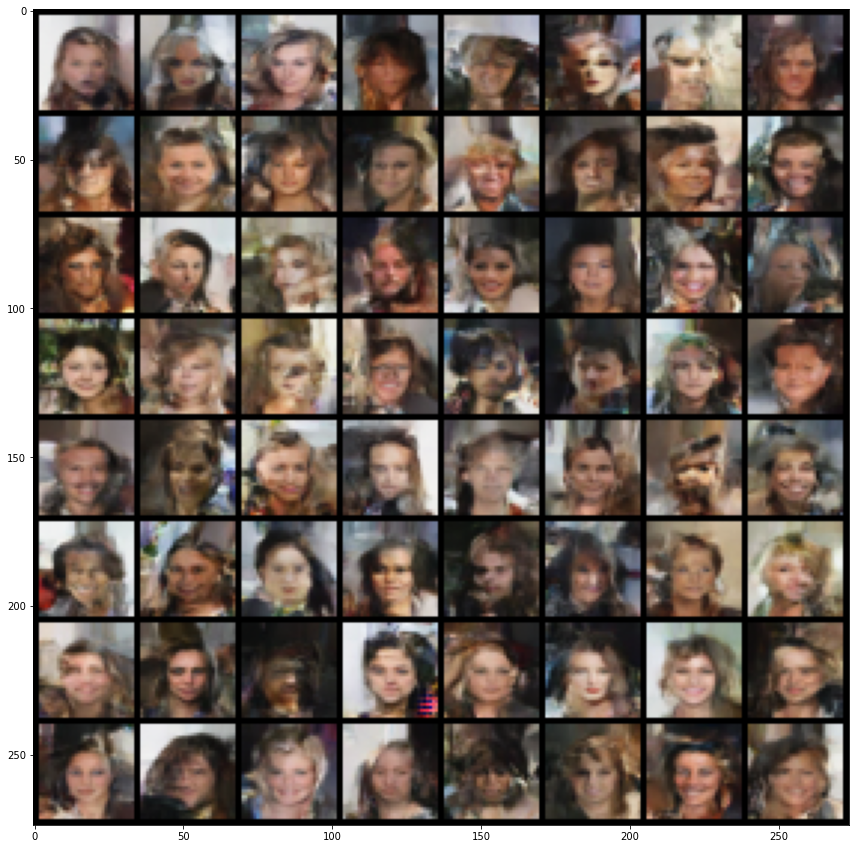

In [8]:
with torch.no_grad():
    sample = net.sample(64, img_size).cpu()
    log_img = make_grid(sample)
plt.figure(figsize=(15,15))
plt.imshow(log_img.permute(1,2,0));

In [9]:
from fid import calculate_fid
print('FID:', calculate_fid(net, dataloader_val, device,
                            img_size=img_size, normalize_input=True))

FID: 54.99456568569343


In [10]:
calculate_fid(net, dataloader_val, device,
              img_size=img_size, normalize_input=True)

54.250882726885465

### NF FID 54.25

### Задача 3 (0.6 балла):

Попробуйте повторить архитектуру VAPNEV из https://arxiv.org/pdf/1611.05209.pdf. Сравните качество (FID) между тремя разными моделями

Здесь вы можете использовать VAE и NF из предыдущих пунктов, необходимо только понять как они совмещаются в оригинальной статье

В отчете напишите, почему по вашему мнению такой подход будет лучше (или может быть хуже) чем обычный VAE?



### Бонусная задача (0.2 балла):

Найдите, реализуйте и сравните с предыдущими моделями еще один интересный способ совмещения NF и VAE

##### Подсказки:

1. Если вы учите на колабе или на наших машинках, вероятнее всего что обучение будет очень долгим на картинках 256х256. Никто не мешает уменьшить разрешение, главное чтобы было видно что генерация выучились и качество было ок

2. Вы можете сделать ваш VAE/NF/VAPNEV условным, придумав как вы будете передавать в него conditional аттрибуты селебы

3. Не забывайте про аугментации


